Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_classif
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [3]:
try:
  from imblearn.over_sampling import SMOTE
except Exception:
  SMOTE = None


# SHAP\LIME
try:
  import shap
except Exception:
  shap = None


try:
  import lime
  import lime.lime_tabular
except Exception:
  lime = None


#стиль графиков
sns.set(style='whitegrid')

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanjeetsinghnaik/used-car-information")

print("Path to dataset files:", path)

100%|██████████| 176k/176k [00:00<00:00, 13.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sanjeetsinghnaik/used-car-information/versions/2


In [5]:
import kagglehub
from pathlib import Path
csv_files = list(Path(path).rglob("*.csv"))
df = pd.read_csv(csv_files[0])

In [6]:
expected_cols = ["Id","year","brand","full_model_name","model_name","price","distance_travelled(kms)","fuel_type","city"]
print('\nОжидаемые колонки:\n', expected_cols)
print('\nНайденные колонки:\n', list(df.columns))

df = df.rename(columns={"distance_travelled(kms)":"distance_km"})


Ожидаемые колонки:
 ['Id', 'year', 'brand', 'full_model_name', 'model_name', 'price', 'distance_travelled(kms)', 'fuel_type', 'city']

Найденные колонки:
 ['Unnamed: 0', 'year', 'brand', 'full_model_name', 'model_name', 'price', 'distance_travelled(kms)', 'fuel_type', 'city']


In [7]:
print('\n--- Общая информация по DataFrame ---')
print(df.info())


print('\n--- Описательная статистика ---')
print(df.describe(include='all'))


# Различные важные статистики
print('\nСредняя цена: ', df['price'].mean())
print('Медианная цена: ', df['price'].median())


print('\nТоп-10 брендов по числу объявлений:')
print(df['brand'].value_counts().head(10))


print('\nГрупповая статистика по бренду (цена):')
print(df.groupby('brand')['price'].agg(['count','mean','median','std']).sort_values('count', ascending=False).head(10))


--- Общая информация по DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       247 non-null    int64  
 1   year             247 non-null    int64  
 2   brand            247 non-null    object 
 3   full_model_name  247 non-null    object 
 4   model_name       247 non-null    object 
 5   price            247 non-null    float64
 6   distance_km      247 non-null    float64
 7   fuel_type        247 non-null    object 
 8   city             247 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.5+ KB
None

--- Описательная статистика ---
        Unnamed: 0         year    brand  \
count    247.00000   247.000000      247   
unique         NaN          NaN       21   
top            NaN          NaN  Hyundai   
freq           NaN          NaN       68   
mean     123.00000  2016.10121

Визуализация распределения цены

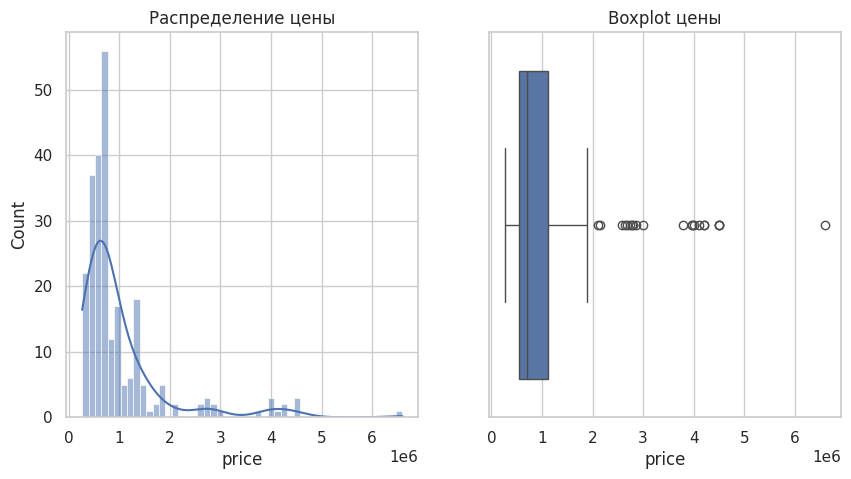

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title('Распределение цены')
plt.subplot(1,2,2)
sns.boxplot(x=df['price'])
plt.title('Boxplot цены')
plt.show()

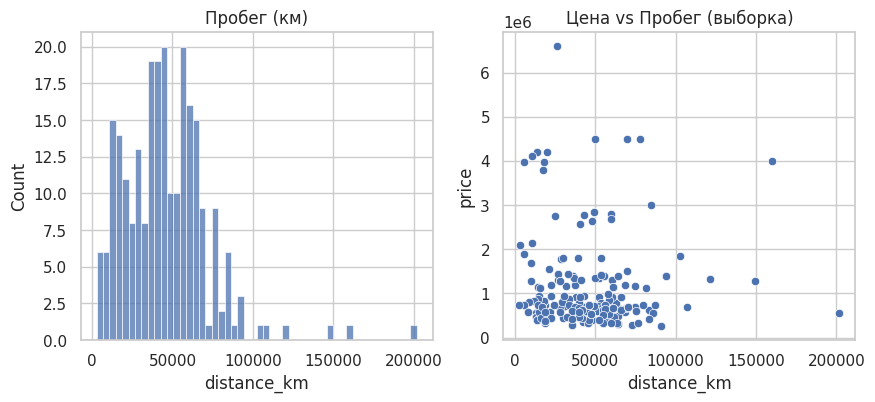

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['distance_km'].dropna(), bins=50)
plt.title('Пробег (км)')
plt.subplot(1,2,2)
sns.scatterplot(data=df.sample(min(1000,len(df))), x='distance_km', y='price')
plt.title('Цена vs Пробег (выборка)')
plt.show()

In [10]:
print('\n--- NumPy: быстрый обзор ---')
A = np.array([[1.0, 2.0], [3.0, 4.0]])
b = np.array([1.0, 2.0])
print('Матрица A:\n', A)
print('Вектор b:', b)
print('Умножение A*b =', A.dot(b))


#SVD
vals, vecs = np.linalg.eig(A)
print('Собственные значения A:', vals)
U, S, VT = np.linalg.svd(A)
print('SVD S:', S)


--- NumPy: быстрый обзор ---
Матрица A:
 [[1. 2.]
 [3. 4.]]
Вектор b: [1. 2.]
Умножение A*b = [ 5. 11.]
Собственные значения A: [-0.37228132  5.37228132]
SVD S: [5.4649857  0.36596619]


# **Feature Engineering**

In [56]:
current_year = datetime.now().year
if 'year' in df.columns:
  df['age'] = current_year - df['year']



df['price_log'] = np.log1p(df['price'].clip(lower=0))

df['price_per_km'] = df['price'] / (df['distance_km'].replace(0, np.nan))


top_brands = df['brand'].value_counts().nlargest(10).index
df['brand_top'] = df['brand'].where(df['brand'].isin(top_brands), other='other')


print('\nПосле feature engineering, колонки:', df.columns.tolist())


После feature engineering, колонки: ['Unnamed: 0', 'year', 'brand', 'full_model_name', 'model_name', 'price', 'distance_km', 'fuel_type', 'city', 'age', 'price_log', 'price_per_km', 'brand_top', 'is_expensive']


# Обработка пропусков

In [12]:
print('\n--- Пропуски по столбцам ---')
print(df.isna().sum())


num_cols = ['age','distance_km']
cat_cols = ['brand_top','fuel_type','city']


--- Пропуски по столбцам ---
Unnamed: 0         0
year               0
brand              0
full_model_name    0
model_name         0
price              0
distance_km        0
fuel_type          0
city               0
age                0
price_log          0
price_per_km       0
brand_top          0
dtype: int64


Pipeline: Preprocessing + Model

In [13]:
#pipeline ColumnTransformer
numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
transformers=[
('num', numeric_transformer, num_cols),
('cat', categorical_transformer, cat_cols)
]
)

In [14]:
# Регрессионный пайплайн
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
('regressor', RandomForestRegressor(n_estimators=50, random_state=42))])


# Классификационный пайплайн
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

In [15]:
median_price = df['price'].median()
df['is_expensive'] = (df['price'] > median_price).astype(int)


# train/test
features = num_cols + cat_cols
X = df[features]
y_reg = df['price'].values
y_clf = df['is_expensive'].values


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# **Линейная регрессия**

In [20]:
linreg_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression())])
linreg_pipe.fit(X_train_reg, y_train_reg)

y_pred_lin = linreg_pipe.predict(X_test_reg)
print('\nLinear Regression: RMSE=', rmse(y_test_reg, y_pred_lin), ' R2=', r2_score(y_test_reg, y_pred_lin))


print('\nПростейшая реализация градиентного спуска (скаляр) — для обучения понимания')

gd_df = df[['age','distance_km']].dropna()
X_gd = gd_df.values

y_gd = df.loc[gd_df.index, 'price'].values.astype(float)


Xg = (X_gd - np.mean(X_gd, axis=0)) / (np.std(X_gd, axis=0) + 1e-8)

Xg = np.c_[np.ones(Xg.shape[0]), Xg]

theta = np.zeros(Xg.shape[1])
alpha = 0.01
for i in range(1000):
    pred = Xg.dot(theta)
    grad = (1 / Xg.shape[0]) * Xg.T.dot(pred - y_gd)
    theta = theta - alpha * grad

print('Параметры (theta):', theta)



Linear Regression: RMSE= 420068.36359982775  R2= 0.760123454756183

Простейшая реализация градиентного спуска (скаляр) — для обучения понимания
Параметры (theta): [ 994936.80256776 -385453.1445469   195613.18166328]


# **Логистическая регрессия**

In [ ]:
log_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('logist', LogisticRegression(max_iter=1000))])
log_pipe.fit(X_train_clf, y_train_clf)


y_pred_log = log_pipe.predict(X_test_clf)
print('\nLogistic Regression — classification report:')
print(classification_report(y_test_clf, y_pred_log))


Logistic Regression — classification report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        22
           1       0.84      0.75      0.79        28

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.79      0.78      0.78        50



# **PCA**


Explained variance ratio PCA: [0.77140681 0.22859319]


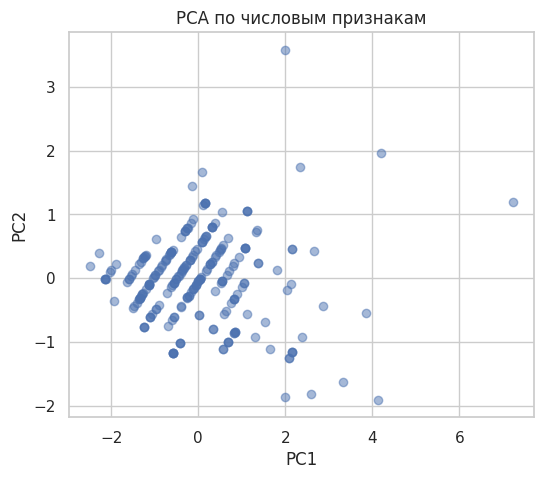

In [ ]:
num_for_pca = ['age','distance_km']
X_num = df[num_for_pca].dropna()
X_num_scaled = StandardScaler().fit_transform(X_num)


pca = PCA(n_components=2)
components = pca.fit_transform(X_num_scaled)
print('\nExplained variance ratio PCA:', pca.explained_variance_ratio_)


plt.figure(figsize=(6,5))
plt.scatter(components[:,0], components[:,1], alpha=0.5)
plt.title('PCA по числовым признакам')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# **Байес**

In [23]:
from sklearn.preprocessing import FunctionTransformer

nb_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), ('nb', GaussianNB())])

try:
    nb_pipe.fit(X_train_clf, y_train_clf)
    print('\nNaive Bayes: accuracy on test =', nb_pipe.score(X_test_clf, y_test_clf))
except Exception as e:
    print('Naive Bayes не обучилась (возможно несовместимые типы после OneHot). Ошибка:', e)



Naive Bayes: accuracy on test = 0.6


# **Random Forest**

In [24]:

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('rf', rf)])
rf_pipe.fit(X_train_reg, y_train_reg)

#RMSE
y_pred_rf = rf_pipe.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_rf)
rmse_val = np.sqrt(mse)
print('\nRandomForest regression RMSE=', rmse_val)



RandomForest regression RMSE= 599172.614809687


# **Support Vector Machine**

In [25]:

svr_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('svr', SVR(kernel='rbf'))])
svr_pipe.fit(X_train_reg, y_train_reg)


y_pred_svr = svr_pipe.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_svr)
rmse_val = np.sqrt(mse)
print('\nSVR RMSE=', rmse_val)



SVR RMSE= 951890.3272184326


KMeans

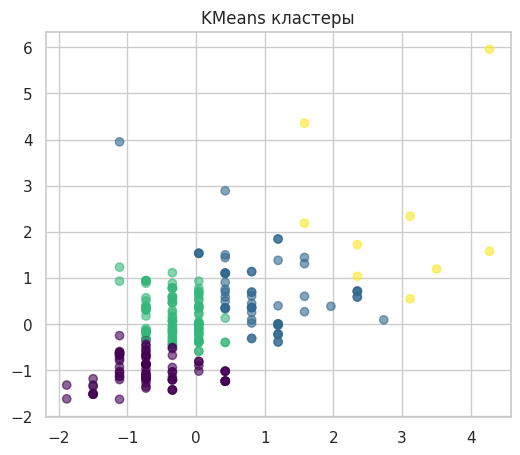

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
km_features = df[num_for_pca].dropna()
km_scaled = StandardScaler().fit_transform(km_features)
km_labels = kmeans.fit_predict(km_scaled)
plt.figure(figsize=(6,5))
plt.scatter(km_scaled[:,0], km_scaled[:,1], c=km_labels, cmap='viridis', alpha=0.6)
plt.title('KMeans кластеры')
plt.show()

# **Outliers**

In [27]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]
print('\nКоличество выбросов по цене (IQR):', outliers_iqr.shape[0])

# IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
df_iso = df[['price','distance_km']].dropna()
iso_pred = iso.fit_predict(df_iso)
print('\nПример меток IsolationForest (-1 = выброс):', np.unique(iso_pred))


Количество выбросов по цене (IQR): 21

Пример меток IsolationForest (-1 = выброс): [-1  1]


# **Feature Selection**

In [30]:
X_reg_fs = preprocessor.fit_transform(X_train_reg)
y_reg_fs = y_train_reg
selector = SelectKBest(score_func=f_regression, k=min(5, X_reg_fs.shape[1]))
selector.fit(X_reg_fs, y_reg_fs)
print('\nSelectKBest scores (top):', selector.scores_)


feat_names_num = num_cols
# one hot
onehot_cols = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
feature_names = list(feat_names_num) + list(onehot_cols)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
print('\nFeature importances (top):')
print(feat_imp)


SelectKBest scores (top): [2.21211059e+01 1.06577591e-02 1.13769071e+00 6.60015940e+00
 6.41888795e-01 7.48100846e+00 4.00968334e+01 2.37915132e+00
 6.82535673e-04 1.31693322e+00 1.71798441e+00 4.88446872e-01
 5.67553125e+01 6.18950574e+01 1.54145437e+00 6.57638573e+01
 0.00000000e+00]

Feature importances (top):
distance_km                0.218911
age                        0.217046
brand_top_other            0.185888
brand_top_Mercedes-Benz    0.158044
fuel_type_Petrol           0.091616
fuel_type_Diesel           0.069023
brand_top_Mahindra         0.019390
brand_top_Toyota           0.015817
brand_top_Hyundai          0.009039
brand_top_Skoda            0.005644
brand_top_Maruti Suzuki    0.003211
fuel_type_Hybrid           0.002159
brand_top_Renault          0.002018
brand_top_Honda            0.001644
brand_top_Volkswagen       0.000322
brand_top_Tata             0.000229
city_Bangalore             0.000000
dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:381: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


# **Class balancing**

In [32]:
if SMOTE is not None:
    print('\nSMOTE установлен, демонстрация баланса классов')
    X_res, y_res = SMOTE(random_state=42).fit_resample(preprocessor.fit_transform(X_train_clf), y_train_clf)
    print('До SMOTE:', np.bincount(y_train_clf), 'После SMOTE:', np.bincount(y_res))
else:
    print('\nSMOTE не установлен — установите imbalanced-learn через pip.')


clf_weighted = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))])
clf_weighted.fit(X_train_clf, y_train_clf)
print('\nRandomForest (class_weight=balanced) accuracy:', clf_weighted.score(X_test_clf, y_test_clf))


SMOTE установлен, демонстрация баланса классов
До SMOTE: [108  89] После SMOTE: [108 108]

RandomForest (class_weight=balanced) accuracy: 0.82


# **Hyperparameter tuning**

In [33]:
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20]
}
search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
search.fit(X_train_reg, y_train_reg)
print('\nЛучшие параметры (RF reg):', search.best_params_)
print('Лучшее CV score:', search.best_score_)

# Random SVM
param_dist = {
    'svr__C': [0.1,1,10],
    'svr__epsilon': [0.1, 0.2, 0.5]
}
search2 = RandomizedSearchCV(svr_pipe, param_distributions=param_dist, n_iter=4, cv=3, n_jobs=-1, random_state=42)
search2.fit(X_train_reg, y_train_reg)
print('\nЛучшие параметры (SVR):', search2.best_params_)


Лучшие параметры (RF reg): {'rf__max_depth': 10, 'rf__n_estimators': 50}
Лучшее CV score: -629825.8070469772

Лучшие параметры (SVR): {'svr__epsilon': 0.2, 'svr__C': 10}


# **GMM**

In [34]:
gmm = GaussianMixture(n_components=3, random_state=42)
X_gmm = km_scaled
gmm.fit(X_gmm)
labels_gmm = gmm.predict(X_gmm)
print('\nGMM convergence:', gmm.converged_)

# первыe 5 точек
print('Responsibilities (first 5):')
print(gmm.predict_proba(X_gmm)[:5])


GMM convergence: True
Responsibilities (first 5):
[[2.79062620e-03 3.92492418e-02 9.57960132e-01]
 [3.02185174e-02 1.20720633e-02 9.57709419e-01]
 [9.10983862e-13 9.99998585e-01 1.41468000e-06]
 [2.43009016e-06 9.78085763e-01 2.19118070e-02]
 [7.08481314e-01 5.33059146e-03 2.86188094e-01]]


In [40]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9af4794ca66dda7094573a5ae3d64e8162ffaa57fa896d253ede56e72135befe
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [43]:
import lime
import lime.lime_tabular


X_train_for_lime = preprocessor.fit_transform(X_train_reg)
lime_exp = lime.lime_tabular.LimeTabularExplainer(
    X_train_for_lime,
    feature_names=feature_names,
    class_names=['price'],
    discretize_continuous=True
)
print('LIME ready — можно объяснять отдельные предсказания.')


LIME ready — можно объяснять отдельные предсказания.


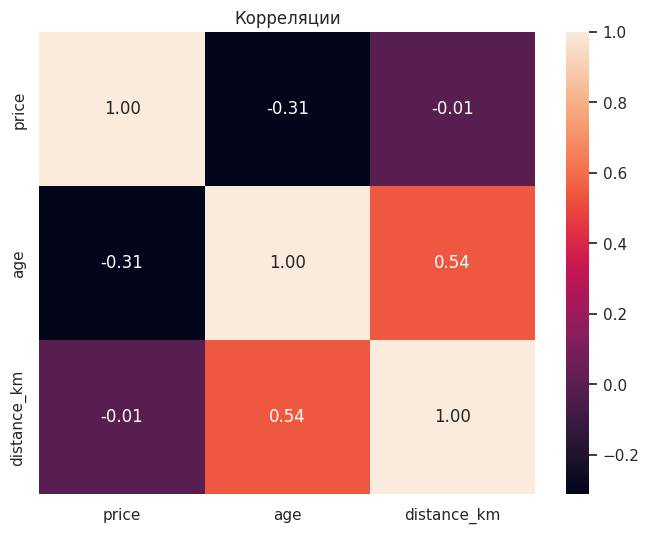

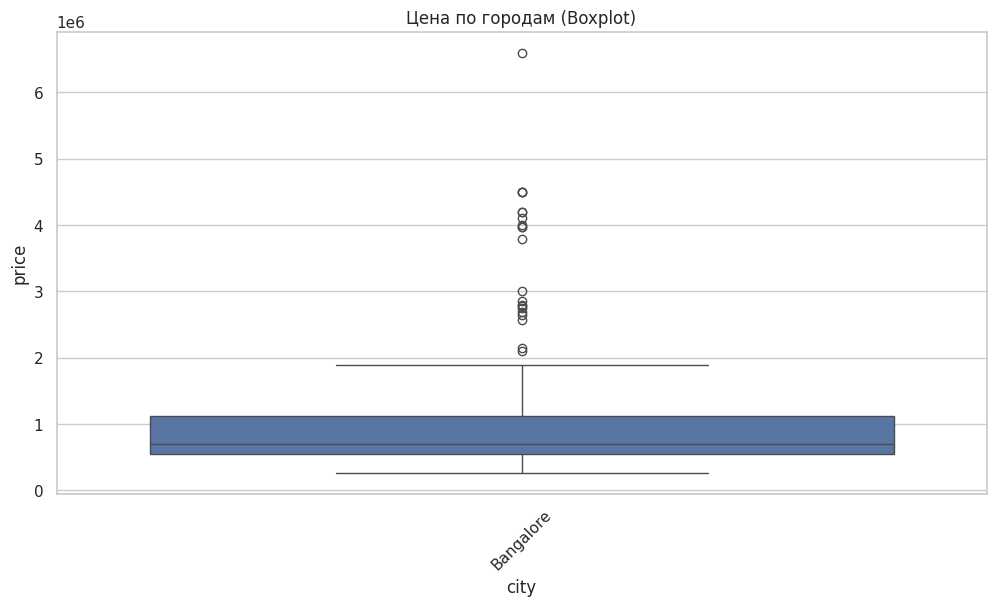

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['price','age','distance_km']].corr(), annot=True, fmt='.2f')
plt.title('Корреляции')
plt.show()

# Различия цен по городам
plt.figure(figsize=(12,6))
order = df.groupby('city')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='city', y='price', order=order)
plt.xticks(rotation=45)
plt.title('Цена по городам (Boxplot)')
plt.show()

In [44]:
import joblib
joblib.dump(rf_pipe, 'rf_price_pipeline.joblib')
print('\nСохранён rf_price_pipeline.joblib')


Сохранён rf_price_pipeline.joblib


In [45]:
with open('streamlit_app.py','w') as f:
    f.write(streamlit_code)
print('\nStreamlit demo saved to streamlit_app.py — откройте/скорректируйте список брендов и запустите локально.')



Streamlit demo saved to streamlit_app.py — откройте/скорректируйте список брендов и запустите локально.


In [48]:
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.3 MB/s eta 0:00:00


In [53]:
#ngrok config add-authtoken 3205bJj6KGq4r2QrNSNfPpX3bLg_85QqNTDWCwtcS3nckQD9S

In [52]:
from pyngrok import ngrok
ngrok.set_auth_token("3205bJj6KGq4r2QrNSNfPpX3bLg_85QqNTDWCwtcS3nckQD9S")

In [54]:
public_url = ngrok.connect(8501)
print("Streamlit доступен по ссылке:", public_url)


Streamlit доступен по ссылке: NgrokTunnel: "https://1c8ffafe7901.ngrok-free.app" -> "http://localhost:8501"


In [55]:
import os
os.system("nohup streamlit run streamlit_app.py --server.port 8501 &")


0